In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#The path to all the images

In [ ]:
# train_path = "/content/drive/MyDrive/Tài liệu môn học/Khoa học nhận thức/Final_project/dataset/train"
# test_path = "/content/drive/MyDrive/Tài liệu môn học/Khoa học nhận thức/Final_project/dataset/test"
# valid_path = "/content/drive/MyDrive/Tài liệu môn học/Khoa học nhận thức/Final_project/dataset/valid"
train_path = "G:/My Drive/Tài liệu môn học/Khoa học nhận thức/Final_project/dataset/train"
test_path = "G:/My Drive/Tài liệu môn học/Khoa học nhận thức/Final_project/dataset/test"
valid_path = "G:/My Drive/Tài liệu môn học/Khoa học nhận thức/Final_project/dataset/valid"
wildfire='wildfire'
nowildfire="nowildfire"

Training files

In [ ]:
train_wildfire_file_path=os.path.join(train_path, wildfire)
train_wildfire_files=[os.path.join(train_wildfire_file_path, file) for file in  os.listdir(train_wildfire_file_path) if file.endswith(".jpg")]
train_wildfire_files.sort()
train_nowildfire_file_path=os.path.join(train_path, nowildfire)
train_nowildfire_files=[os.path.join(train_nowildfire_file_path, file) for file in os.listdir(train_nowildfire_file_path) if file.endswith(".jpg")]
train_nowildfire_files.sort()
print("Number of train wildfire files:", len(train_wildfire_files))
print("Number of train nowildfire files:", len(train_nowildfire_files))

Number of train wildfire files: 15750
Number of train nowildfire files: 14500


Testing files

In [ ]:
test_wildfire_file_path=os.path.join(test_path, wildfire)
test_wildfire_files=[os.path.join(test_wildfire_file_path, file) for file in  os.listdir(test_wildfire_file_path) if file.endswith(".jpg")]
test_wildfire_files.sort()
test_nowildfire_file_path=os.path.join(test_path, nowildfire)
test_nowildfire_files=[os.path.join(test_nowildfire_file_path, file) for file in os.listdir(test_nowildfire_file_path) if file.endswith(".jpg")]
test_nowildfire_files.sort()
print("Number of test wildfire files:", len(test_wildfire_files))
print("Number of test nowildfire files:", len(test_nowildfire_files))

Number of test wildfire files: 3480
Number of test nowildfire files: 2820


Valid files

In [ ]:
valid_wildfire_file_path=os.path.join(valid_path, wildfire)
valid_wildfire_files=[os.path.join(valid_wildfire_file_path, file) for file in  os.listdir(valid_wildfire_file_path) if file.endswith(".jpg")]
valid_wildfire_files.sort()
valid_nowildfire_file_path=os.path.join(valid_path, nowildfire)
valid_nowildfire_files=[os.path.join(valid_nowildfire_file_path, file) for file in os.listdir(valid_nowildfire_file_path) if file.endswith(".jpg")]
train_nowildfire_files.sort()
print("Number of valid wildfire files:", len(valid_wildfire_files))
print("Number of valid nowildfire files:", len(valid_nowildfire_files))

Number of valid wildfire files: 3480
Number of valid nowildfire files: 2829


# Load train data from dataset

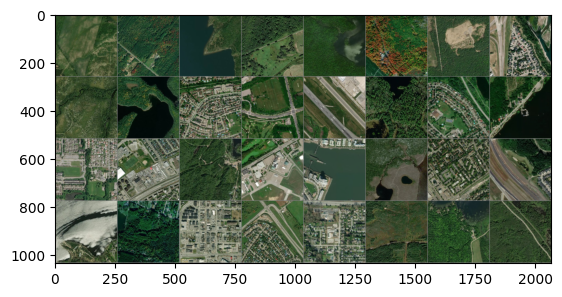

In [ ]:
# Define transformations (optional)
image_size = 256
batch_size = 32
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

# Load dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_path, transform=transform)
# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))

#Convolutional Neural Network

In [ ]:
class ClassificationNetwork(nn.Module):
    def __init__(self, num_input_channels: int = 3):
        super().__init__()
        # self.conv_list = []
        # self.batch_norm = []
        input_channels = num_input_channels
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 16, kernel_size= 3)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size= 3)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size= 3)
        self.avg_pool = nn.AvgPool2d(kernel_size = 12, stride = 1)
        self.linear = nn.Linear(in_features= 64, out_features= 2)

    def forward(self, x):
      out = self.max_pool(self.batch_norm1(F.relu(self.conv1(x))))
      out = self.max_pool(self.batch_norm2(F.relu(self.conv2(out))))
      out = self.max_pool(self.batch_norm3(F.relu(self.conv3(out))))
      out = self.max_pool(self.batch_norm4(F.relu(self.conv4(out))))
      out = self.avg_pool(F.relu(self.conv5(out))).squeeze()
      out = F.softmax(self.linear(out), dim=1)

      return out

class_net = ClassificationNetwork().to(device)
model_folder = "G:/My Drive/Tài liệu môn học/Khoa học nhận thức/Final_project/model"
if not os.path.exists(os.path.join(model_folder, "model.pth")):
    torch.save(class_net.state_dict(), os.path.join(model_folder, "model.pth"))
else:
    class_net.load_state_dict(torch.load(os.path.join(model_folder, "model.pth"), map_location= device))

# Update model

## Optimize

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(class_net.parameters(), lr=0.001, momentum=0.9)

## Training

In [ ]:
best_loss =  float('inf')
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = class_net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            if abs(running_loss/10) < abs(best_loss):
                best_loss = running_loss/10
                torch.save(class_net.state_dict(), os.path.join(model_folder, "best_model.pth"))
                print("Best loss:", best_loss)
            running_loss = 0.0
            torch.save(class_net.state_dict(), os.path.join(model_folder, "model.pth"))
    # Testing
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = class_net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    accuracy = 100 * correct / total
    print("Accuracy: {}%".format(accuracy))
print('Finished Training')

KeyboardInterrupt: 